model_training

In [1]:
from tqdm import tqdm
import sys
from sklearn.model_selection import train_test_split
from torch.utils.data import (
    DataLoader, Dataset, RandomSampler, SubsetRandomSampler, Subset, SequentialSampler
)
from MTGNet import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from search import *
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy
import random
import argparse
import pickle
from util import *
# Multitask performance
# Gain distribution
# Estimation Error

In [2]:
# hyperparam
dataset = '3000addpair' #6tasks 28tasks 27tasks 8tasks 5tasks 
# strategy = 'pertask' # pertask or perstep
temperature = 0.00001
ratio = '1' # for 6tasks and 27 tasks '0.1' '0.5' '1'  for cv 5tasks options ->'smalldata' 'smallnet' and '1'
learning_rate = 0.001
num_layers = 2
gpu_id = '0'
ensemble_num = 2
end_num= 2
num_hidden = 128

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# if theres a RuntimeWarning: invalid value encountered in true_divide, the model will select group the largest pred gain
total_pred_traj = model_training(dataset = dataset, ratio = ratio, temperature = temperature, num_layers= num_layers, num_hidden=num_hidden,ensemble_num= ensemble_num, gpu_id = gpu_id, end_num = end_num)

load 6tasks
7
max y 0.4153
min y -0.031180000000000003
cost 0
valid loss total [0.11233934]
train loss [0.01167331]
valid loss [0.08042692]
cost 1
valid loss total [0.11233934 0.03650544]
train loss [0.01167331 0.01883083]
valid loss [0.08042692 0.04697167]
cost 2


load 27tasksaddpair
load 27tasksaddpair
load 27tasksaddpair


/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


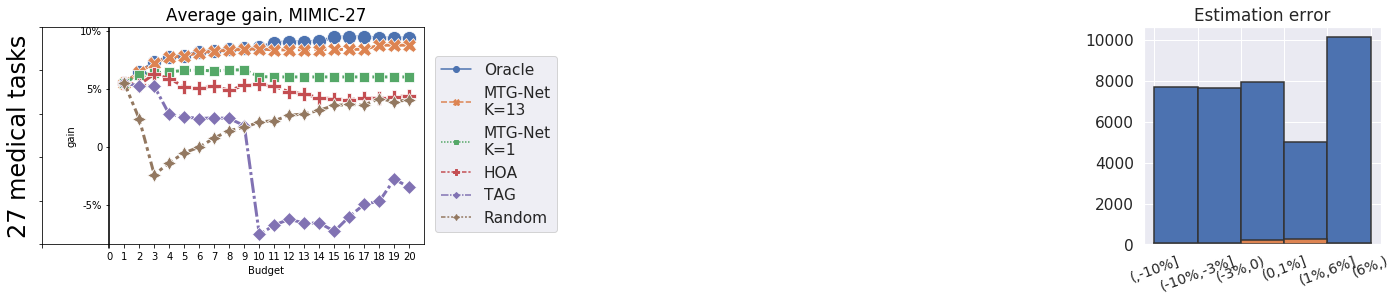

In [4]:
# search for multiple
ratio = '0.1'
dataset = '3000addpair'
import pickle  
with open('./log/27tasksaddpair/'+ratio+'/pred_pertask_trajactive.pkl', "rb") as fp:
    pred_traj = pickle.load(fp)
select_index = []
pred_traj = np.array(pred_traj)[[27,31,35,-1]]
x,y,testx,testy = getdataset('27tasksaddpair',ratio)
validy = y
validx = x
HOApath = './gain_data/3000addpair/27tasksHOA'+ ratio.replace('.', '')+'_clean.csv'
TAGpath = './gain_data/3000addpair/27tasksTAGHOA'+ ratio.replace('.', '')+'_clean.csv'
sample_num = 3000
search_num = 5
total_gain_traj,total_select = approx_optimal(sample_num,search_num,pred_traj,testy,testx,dataset)
total_HOA_gain_traj,HOA_select = approx_optimal(sample_num,search_num,pd.read_csv(HOApath,header= None , sep=' ').values,testy,testx,dataset)
oracle_gain_traj,oracel_select = approx_optimal(sample_num,search_num,validy,testy,testx,dataset)
test_oracle_traj,oracel_select = approx_optimal(sample_num,search_num,testy,testy,testx,dataset)
TAG_gain_traj,TAG_select = approx_optimal(sample_num,search_num,pd.read_csv(TAGpath,header= None , sep=' ').values,testy,testx,dataset)

sample_num = 26
search_num = 1
budget = 27
x,y,testx,testy = getdataset('27tasksaddpair',ratio)
gain_1 = []
gain_6 = []
total_traj = []
for iteration in range(100):
    rand_traj = []
    for num in range(1,27):
        while(True):
            sample_list = np.random.choice(np.arange(len(x)) ,size = num,replace = False )
            a = np.zeros((len(x[0])),)
            for i in x[sample_list]:
                a = a+i
            if(len(a[a==0])==0 ):
                value = np.zeros((len(x[0])))
                selected = validy[sample_list]
                test = testy[sample_list]
                testmask = testx[sample_list]
                for i in range(len(y[0])):
                    value[i] = test[np.argmax(selected[:,i])][i]
                break
        rand_traj.append(value.sum())
    total_traj.append(np.array(rand_traj))
for i in range(20):
    while(True):
        sample_list = np.random.choice(np.arange(len(x)) ,size = budget*5,replace = False )
        a = np.zeros((len(x[0])),)
        for i in x[sample_list]:
            a = a+i
        if(len(a[a==0])==0 ):
            selected = validy[sample_list]
            test = testy[sample_list]
            testmask = testx[sample_list]
        break
    random_gain_traj6,random_select = approx_optimal(sample_num,search_num,selected,test,testmask,dataset)
    while(True):
        sample_list = np.random.choice(np.arange(len(x)) ,size = budget,replace = False )
        a = np.zeros((len(x[0])),)
        for i in x[sample_list]:
            a = a+i
        if(len(a[a==0])==0 ):
            selected = validy[sample_list]
            test = testy[sample_list]
            testmask = testx[sample_list]
        break
    random_gain_traj,random_select = approx_optimal(sample_num,search_num,selected,test,testmask,dataset)
    gain_6.append(random_gain_traj6)
    gain_1.append(random_gain_traj)

import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
cut_length = 20
# NN_gain0 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[0])[:cut_length]/28})
NN_gain1 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[0])[:cut_length]/27 })
NN_gain2 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[1])[:cut_length]/27 })
NN_gain5 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[2])[:cut_length]/27 })
rand_group = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_traj).mean(0)[:cut_length]/27 })
# NN_gain10 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[4])[:cut_length]/28})
NN_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_gain_traj[-1])[:cut_length]/27 })
HOA_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(total_HOA_gain_traj)[:cut_length]/27 })
oracle_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(oracle_gain_traj)[:cut_length]/27 })
test_oracle = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(test_oracle_traj)[:cut_length]/27 })
random_gain1 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(gain_1).mean(0)[:cut_length]/27 })
random_gain5 = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(gain_6).mean(0)[:cut_length]/27 })
TAG_gain = pd.DataFrame({'budget':list(range(1,cut_length+1)),'gain': np.array(TAG_gain_traj)[:cut_length]/27 })
HOA_gain['type'] = 'HOA'
NN_gain['type'] = 'MTG-Net\nK=13'
NN_gain1['type'] = 'MTG-Net\nK=1'
NN_gain2['type'] = 'MTG-Net\nK=5'
NN_gain5['type'] = 'MTG-Net\nK=9'
oracle_gain['type'] = 'Oracle'
test_oracle['type'] = 'Test orcale'
TAG_gain['type'] = 'TAG'
rand_group['type'] = 'Random'
random_gain1['type'] = '(strong) random gain 27 sample'
random_gain5['type'] = '(strong) random gain 27*5 sample'
import seaborn as sns
all_gain = pd.concat([oracle_gain,NN_gain,NN_gain1,HOA_gain,TAG_gain,rand_group],axis=0)
gs = gridspec.GridSpec(2, 140)
plt.figure(figsize=(24,4))
ax_title = plt.subplot(gs[:,:7])
ax_title.grid(False)
ax_title.set_facecolor('white')
ax_title.set_xticklabels([])
ax_title.set_ylabel('27 medical tasks',fontsize=24)
ax_title.set_yticklabels([])
ax1 = plt.subplot(gs[:,7:40])
sns.set(font_scale=1.4)
sns.lineplot(x="budget", y="gain",hue="type",style='type', markers=True,linewidth = 3,markersize=14, data=all_gain, ax = ax1)
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
ax1.set_yticks([-0.05,0,0.05,0.10])
ax1.set_yticklabels(['-5%','0','5%','10%',])
ax1.set_xlabel('Budget')
plt.legend(loc="upper left",bbox_to_anchor=(1.01,0.9))
plt.title("Average gain, MIMIC-27")
ax2 = plt.subplot(gs[:,115:149])
plt.title('Gain distribution')
x,y,testx,testy = getdataset('27tasksaddpair',ratio)
HOA = pd.read_csv(HOApath,header= None , sep=' ').values
import copy
y_n2 = y
P_n2 = HOA
ground_truth = y
range0 = np.percentile(y[y<0],0)
range1 = np.percentile(y[y<0],33)
range2 = np.percentile(y[y<0],66)
range3 = 0
range4 = np.percentile(y[y>0],33)
range5 = np.percentile(y[y>0],66)
range6 = np.percentile(y[y>0],100)
boxplot_x = np.array([range0,range1,range2,range3,range4,range5,range6])
name_list = ['(,-10%]','(-10%,-3%]','(-3%,0)','(0,1%]','(1%,6%]','(6%,)']
num_list = np.array([0.00,0.005,0.01,0.015])
total_width, n = 0.001, 2
width = total_width
num_list1 = num_list- width
bin_sel = np.array(list(range(-600,600,100)))*0.001
model_pred = pred_traj[-1]
total_output = copy.deepcopy(model_pred)
total_output[total_output==-99] = 0

ycopy = copy.deepcopy(y[y!=0])
boxplot_x[-1] = boxplot_x[-1] + 0.1
count = 10
for i in range(len(boxplot_x)-1):
    ycopy[(ycopy<boxplot_x[i+1]) & (ycopy>=boxplot_x[i])] = count
    count = count+1
plt.xticks([10,11,12,13,14,15],name_list,fontsize=14,rotation=20)
plt.hist(ycopy, bins=[10,11,12,13,14,15], normed=0, color=sns.color_palette()[0],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='All', alpha=1)

ycopy = copy.deepcopy(y[2843:][y[2843:]!=0])
boxplot_x[-1] = boxplot_x[-1] + 0.1
count = 10
for i in range(len(boxplot_x)-1):
    ycopy[(ycopy<boxplot_x[i+1]) & (ycopy>=boxplot_x[i])] = count
    count = count+1
plt.hist(ycopy, bins=[10,11,12,13,14,15], normed=0, color=sns.color_palette()[1],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='Pairwise', alpha=1)
plt.title('Estimation error')
plt.savefig('27tasks_mimic_'+str(ratio)+'.pdf',bbox_inches = 'tight')
plt.tight_layout()
plt.show()

/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fcb3bd8cf60> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fcb3bd8cd68> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <mat

load 27tasksaddpair


/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/covpreduser/.conda/envs/sxz/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


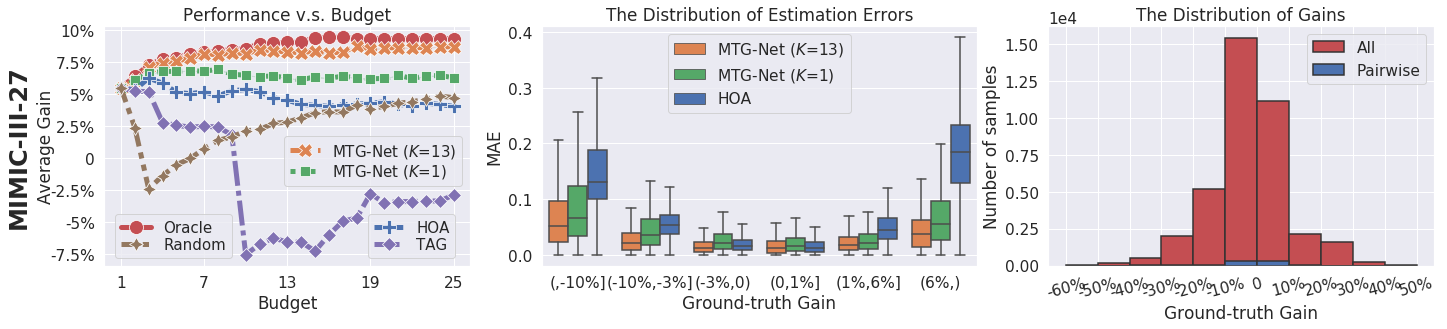

In [8]:
plt.switch_backend('agg')
plt.rcParams['pdf.use14corefonts'] = True
NN_gain2 = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(total_gain_traj[1])[:25]/27 })
NN_gain5 = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(total_gain_traj[2])[:25]/27 })
rand_group = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(total_traj).mean(0)[:25]/27 })
HOA_gain = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(total_HOA_gain_traj)[:25]/27 })
oracle_gain = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(oracle_gain_traj)[:25]/27 })
test_oracle = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(test_oracle_traj)[:25]/27 })
random_gain1 = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(gain_1).mean(0)[:25]/27 })
random_gain5 = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(gain_6).mean(0)[:25]/27 })
TAG_gain = pd.DataFrame({'budget':list(range(1,26)),'gain': np.array(TAG_gain_traj)[:25]/27 })
HOA_gain['type'] = 'HOA'
NN_gain['type'] = 'MTG-Net ($K$=13)'
NN_gain1['type'] = 'MTG-Net ($K$=1)'
NN_gain2['type'] = 'MTG-Net K=5'
NN_gain5['type'] = 'MTG-Net K=9'
oracle_gain['type'] = 'Oracle'
test_oracle['type'] = 'Test orcale'
TAG_gain['type'] = 'TAG'
rand_group['type'] = 'Random'
random_gain1['type'] = '(strong) random gain 27 sample'
random_gain5['type'] = '(strong) random gain 27*5 sample'
import seaborn as sns
all_gain = pd.concat([oracle_gain,NN_gain,NN_gain1,HOA_gain,TAG_gain,rand_group],axis=0)
gs = gridspec.GridSpec(2, 140)
plt.figure(figsize=(24.9,4.4))
ax_title = plt.subplot(gs[:,:6])
ax_title.grid(False)
ax_title.set_facecolor('white')
ax_title.set_xticklabels([])
ax_title.set_ylabel('MIMIC-III-27',fontsize=24,fontweight="bold")
ax_title.set_yticklabels([])
ax1 = plt.subplot(gs[:,6:43])
# plt.figure(figsize=(20,4))
sns.set(font_scale=1.4)
mypalette = [sns.color_palette()[3],sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0],sns.color_palette()[4],sns.color_palette()[5]]
sns.lineplot(x="budget", y="gain",hue="type",style='type', markers=True,linewidth = 5,markersize=14,palette=mypalette, data=all_gain, ax = ax1,ci=0,markevery=1)
plt.ylabel('Average Gain',labelpad=-5)
ax1.set_xticks([1,7,13,19,25])
ax1.set_yticks([-0.075,-0.05,-0.025,0,0.025,0.05,0.075,0.10])
ax1.set_yticklabels(['-7.5%','-5%','-2.5%','0','2.5%','5%','7.5%','10%',])
ax1.set_xlabel('Budget')
l1 = ax1.legend(['Oracle','_','_','_','_','Random'],ncol = 1,loc='lower left',bbox_to_anchor=(0.01,0.00),fontsize=15,columnspacing=0.15,labelspacing=0.15)
l2 = ax1.legend(['_','_','_','HOA','TAG','_'],ncol = 1,loc='lower left',bbox_to_anchor=(0.7,0.00),fontsize=15,columnspacing=0.15,labelspacing=0.15)
ax1.add_artist(l1)
ax1.add_artist(l2)
ax1.legend(['_','MTG-Net ($K$=13)','MTG-Net ($K$=1)'],ncol = 1,loc='lower left',bbox_to_anchor=(0.47,0.3),fontsize=15,columnspacing=0.15,labelspacing=0.15)
plt.title("Performance v.s. Budget")
ax2 = plt.subplot(gs[:,101:147])
plt.title('The Distribution of Gains')
x,y,testx,testy = getdataset('27tasksaddpair',ratio)
HOA = pd.read_csv(HOApath,header= None , sep=' ').values
import copy
y_n2 = y
P_n2 = HOA
ground_truth = y
range0 = np.percentile(y[y<0],0)
range1 = np.percentile(y[y<0],33)
range2 = np.percentile(y[y<0],66)
range3 = 0
range4 = np.percentile(y[y>0],33)
range5 = np.percentile(y[y>0],66)
range6 = np.percentile(y[y>0],100)
boxplot_x = np.array([range0,range1,range2,range3,range4,range5,range6])
# [-0.8542 -0.1027 -0.0312  0.      0.0197  0.0599  0.503 ]
name_list = ['(,-10%]','(-10%,-3%]','(-3%,0)','(0,1%]','(1%,6%]','(6%,)']
num_list = np.array([0.00,0.005,0.01,0.015])
# num_list1 = [1,2,3,1]
total_width, n = 0.001, 2
width = total_width
num_list1 = num_list- width
bin_sel = np.array(list(range(-600,600,100)))*0.001
total_output = copy.deepcopy(model_pred[-1])
total_output[total_output==-99] = 0
name_list = ['-60%','-50%','-40%','-30%','-20%','-10%','0','10%','20%','30%','40%','50%']
plt.xticks(bin_sel,name_list)
plt.hist(y[y!=0], bins=bin_sel, normed=0, color=sns.color_palette()[3],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='All', alpha=1)
plt.hist(y[2843:][y[2843:]!=0], bins=bin_sel, normed=0, color=sns.color_palette()[0],linewidth=1.5,edgecolor =(0.2,0.2,0.2),label='Pairwise', alpha=1)
plt.xticks(rotation=15)
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
plt.legend()
plt.xlabel('Ground-truth Gain')
plt.ylabel('Number of samples')

name_list = ['(,-10%]','(-10%,-3%]','(-3%,0)','(0,1%]','(1%,6%]','(6%,)']

average_boxplot= []
total_output = copy.deepcopy(model_pred)[-1]
for i in range(len(boxplot_x)-1):
    average_boxplot.append(abs(P_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] - y_n2[((y_n2>boxplot_x[i]) & (y_n2<boxplot_x[i+1]))] ))
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ))
import pandas as pd
df_average = pd.DataFrame(columns=['type','MAE','Range'])
for i in range(len(name_list)):
    for j in average_boxplot[i]:
        data = {'type':'HOA',
                'MAE':[j],
                'Range':name_list[i]}
        df_average = pd.concat([df_average,pd.DataFrame(data)],axis=0)

import pandas as pd
df_NN1 = pd.DataFrame(columns=['type','MAE','Range'])
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        data = {'type':'MTG-Net ($K$=13)',
                'MAE':[j],
                'Range':name_list[i]}
        df_NN1 = pd.concat([df_NN1,pd.DataFrame(data)],axis=0)

total_output = copy.deepcopy(model_pred[-2])
NN_boxplot = []
for i in range(len(boxplot_x)-1):
    NN_boxplot.append(abs(total_output[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] - ground_truth[((ground_truth>boxplot_x[i]) & (ground_truth<boxplot_x[i+1]))] ))
import pandas as pd
df_NN2 = pd.DataFrame(columns=['type','MAE','Range'])
for i in range(len(name_list)):
    for j in NN_boxplot[i]:
        data = {'type':'MTG-Net ($K$=1)',
                'MAE':[j],
                'Range':name_list[i]}
        df_NN2 = pd.concat([df_NN2,pd.DataFrame(data)],axis=0)

all_average = pd.concat([df_NN1,df_NN2,df_average],axis=0)
ax3 = plt.subplot(gs[:,50:94])
sns.boxplot(x="Range", y="MAE",
                hue="type", palette= (sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0]),
                data=all_average,showfliers = False,saturation=1 )
                # ,
                # ax=ax3
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles[0:], labels=labels[0:])
plt.xlabel('Ground-truth Gain')
plt.title('The Distribution of Estimation Errors')

plt.savefig('27tasks_mimic2_'+str(ratio)+'.pdf',bbox_inches = 'tight')
plt.tight_layout()
plt.show()